In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from ase import Atoms
from ase.cluster import Cluster, Icosahedron
from ase import units as un
import ase.io
from IPython.core.display import Image
import numpy as np
from numpy import array, sum, std, mean
import scipy.interpolate as inter
from glob import glob
from tqdm.auto import tqdm

## Our goal

Naszym celem jest zbadanie zachowania warstwowych nanocząstek Fe-Pt w wysokich temperaturach. Mamy nadzieję wyznaczyć granicę stabilności termicznej takich nanocząstek. Poniższa animacja pokazuje funkcję kalorymetryczną ($E_P - E_K$) nanocząstki jako funkcję temperatury, razem z odcinkami animacji przedstawiającymi wygląd nanocząstki w danej temperaturze.

<video height=450 preload="metadata" type="video/webm" autoplay controls
    src="http://wolf.ifj.edu.pl/~jochym/p/notebooks/anim_e.webm" >
</video>

## Struktura nanocząstki

Aby móc prowadzić rachunki musimy najpierw zdefiniować badaną strukturę. 
W naszym przypadku będzie to ikosaedryczna (dwudziestościenna) cząstka złożona z 55 atomów (1Pt+12Fe+42Pt).
Szczęśliwie, biblioteka którą się posługujemy (ASE - Atomistic Simulation Environment) zawiera funkcję 
budującą dwudziestościenne cząstki.

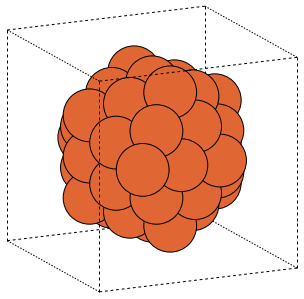

In [2]:
ico=Icosahedron("Fe", 3); ico.center(vacuum=2.0)
ase.io.write('fe-ico.png', ico, show_unit_cell=2, rotation='115y,15x')
Image(filename='fe-ico.png')

## Struktura warstwowa 

*Cebula ma warstwy - Nanocząstki mają warstwy ... i nie są jak tort!*

Aby uzyskać zamierzoną strukturę warstwową wykorzystamy tę samą funkcję aby zidentyfikować kolejne warstwy cząstki i zdefiniować ich skład - na przemian Fe i Pt.

In [3]:
def LC_ico(a1,a2,ln):
    '''
    Stwórz strukturę warstwową rzędu ln 
    o naprzemiennych warstwach atomów a1, a2
    '''
    ico=Icosahedron(a1,ln)
    icon=ico.get_atomic_numbers()
    for l in range(ln,0,-1):
        if (ln-l)%2 :
            a=a1
        else :
            a=a2
        il=Icosahedron(a,l)
        an=il.get_atomic_numbers()
        icon[:len(an)]=an
    ico.set_atomic_numbers(icon)
    return ico      

Upewnijmy się że nasza procedura działa poprawnie rysując stworzoną komórkę w przekroju. W tym celu wykorzystamy możliwość wyboru elementów listy przy pomocy tablicy logicznej (*fancy indexing*). Taka konstrukcja jest specyficzna dla języka Python.

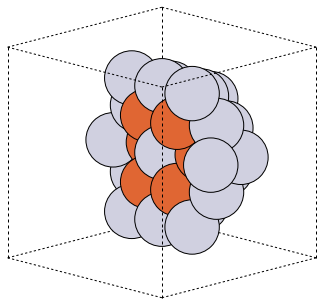

In [4]:
lc=LC_ico("Fe","Pt",3); lc.center(vacuum=2.0)  # Warstwowa nanocząstka
cut=lc.get_center_of_mass()[2]                 # Płaszczyzna cięcia (CM)
ase.io.write('cebula.png',
             lc[[a.index for a in lc if a.position[2]>=cut]], # Selekcja atomów
             show_unit_cell=2, rotation='135y,15x')
Image(filename='cebula.png')

## Dynamika molekularna - co to jest?

W naszych obliczeniach posłużymy się metodą *dynamiki molekularnej*. Jest to metoda badania zachowania układów atomowych przez numeryczne rozwiązanie ich równania ruchu a następnie analizę tak uzyskanej trajektorii.

Równanie ruchu atomu o indeksie $i$:

$$
\frac{d^2{\mathbf x}_i}{{dt}^2}=\frac{{\mathbf F}_i}{m_i}
$$

rozwiązywane jest klasycznymi metodami numerycznego całkowania równan ruchu (np. algorytm *Verleta*), siły ${\mathbf F}_i$ pochodzą z rachunku *ab-initio* (siły *Hellmanna-Feynmana*).

Dla naszej struktury przeprowadzamy serię obliczeń w których nadajemy atomom różną średnią energię kinetyczną - czyli temperaturę: 

$$
T=\frac{2\langle E_k \rangle}{3k_B}.
$$

W rezultacie otrzymujemy trajektorie układu, które poddajemy dalszej analizie. 

## Obliczenia ab initio

*Ja, żeby nie tracić czasu, przygotowałem już sobie wcześniej ...*
(Adam Słodowy)

Obliczenia *ab-initio* użyte tutaj trwały długie miesiące. Samo ich przygotowanie i przeprowadzenie jest zabiegiem technicznym i nie jest szczególnie kształcące. Potrzebne wyniki tych obliczeń - w postaci kolekcji trajektorii - znajdują się w kartotece `data` w materiałach do ćwiczeń.

In [5]:
md = {}
dt = 10.0 # fs
print('T= ', end='')
for fn in glob('data/md_T_*.traj'):
    T = int(fn.split('_')[-1][:-5])
    print(f'{T}', end=' ')
    md[T] = (dt, ase.io.Trajectory(fn))
print('K')

T= 1400 950 1425 1450 1100 850 500 1300 1200 1500 1000 1600 900 300 150 700 2000 1350 600 800 1700 K


## Analiza trajektorii
W materiałach ćwiczeniowych znajduje się też kilka dalszych przykładów analizy uzyskanych trajektorii. Tutaj zajmiemy się uzyskaniem wykresu kalorymetrycznego ($E_p - E_k$ jako funkcja temperatury $T$), który pozwoli nam rozpoznać temperaturę topnienia nanocząstki o platynowej powierzchni. 
* Enargia potencjalna wyliczana jest przez program *ab-initio* i zawarta jest we wczytanych danych
* Energię kinetyczną musimy wyliczyć na podstawie trajektorii

$$
E_k(t_i)=\sum_{n=1}^{N_{at}}\frac{m_n {\mathbf v_n}(t_{i})^2}{2}=\sum_{n=1}^{N_{at}}\frac{m_n ({\mathbf x_n}(t_{i+1})-{\mathbf x_n}(t_{i}))^2}{2}
$$

### Realizacja obliczeń

Aby wyliczyć potrzebne wielkości musimy napisać kilka krótkich fragmentów programu. Poniższe funkcje wyliczają prędkości cząstek, a następnie na ich podstawie: energie kinetyczne atomów oraz chwilową temperaturę nanocząstki.

In [6]:
def calc_velocities(a1,a2,dt):
    '''
    Wyliczenie prędkości atomów na podstawie pozycji a1, a2
    oraz odstępu czasu dt
    '''
    dx=(a2.get_positions()-a1.get_positions())
    c=Atoms(a2)
    tv=sum(c.get_cell(),axis=0)/2
    c.set_positions(dx)
    c.translate(tv)
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate(-tv)
    return c.get_positions()/dt

In [7]:
def calc_kinen(tr,dt):
    '''
    Wyliczenie energii kinetycznej atomów w trajektorii tr 
    przy kroku czasowym dt.
    '''
    m=tr[0].get_masses()
    Ek=[m*sum(calc_velocities(a1,a2,dt)**2,axis=1)/2 
                    for a1,a2 in zip(tr[:-1],tr[1:])]
    return Ek
    
def calc_temp(tr,dt):
    '''
    Wyliczenie chwilowej temperatury w trajektorii tr
    przy kroku czasowym dt
    '''
    eka=calc_kinen(tr,dt)
    ek=sum(eka,axis=-1)
    ekd=std(eka,axis=-1)
    n=len(tr[0].get_masses())
    c=n/(n-1)
    return 2*c*ek/(3*n*un.kB), 2*c*ekd/(3*un.kB)

### Kinetic energy fluctuations

The DFT calculations have been performed in the NVT regime with a Nose thermostat

Przekonajmy się nak wyglądają fluktuacje temperatury układu. Ponieważ oryginalne obliczenia trajektorii zostały wykonane w reżimie układu w kontakcie z termostatem oczekujemy że temperatura będzie fluktuować wokoło założonych temperatur symulacji.

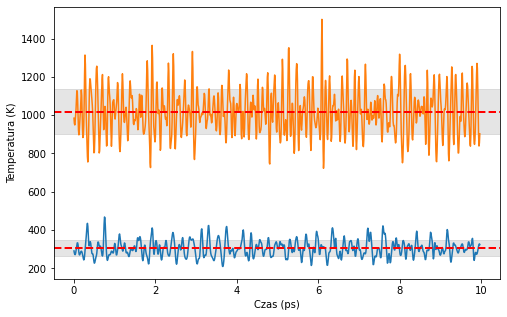

In [8]:
plt.figure(figsize=(8,5))
for T in [300, 1000]:
    dt,tr=md[T]; temp,_=calc_temp(tr,dt*un.fs)
    avgT=mean(temp) ; devT=std(temp)
    plt.plot(dt*np.arange(len(temp))/1000,temp,'-')
    plt.axhline(avgT,ls='--',color='r',lw=2)
    plt.axhspan(avgT-devT,avgT+devT,color='C7',alpha=0.2)
plt.xlabel('Czas (ps)'); plt.ylabel('Temperatura (K)');

### Kalorymetric curve

Calculate:
 * Potential energy (from *ab-initio* data)
 * Kinetic energy 
 * Temperature

In [9]:
dat=[]
for T in tqdm(sorted(md)):
    dt,tr=md[T]
    epot=array([s.get_potential_energy() for s in tr])
    epot=((epot[:-1]+epot[1:])/2)
    ekin=sum(array(calc_kinen(tr,dt*un.fs)),axis=-1)
    etot=epot+sum(ekin,axis=-1)
    temp_v, temp_d=calc_temp(tr,dt*un.fs)
    atemp=mean(temp_v)
    dat.append([atemp, mean(epot), mean(ekin),
                mean((etot-mean(etot))**2)/(un.kB*(atemp**2))])
dat=array(dat).T

  0%|          | 0/21 [00:00<?, ?it/s]

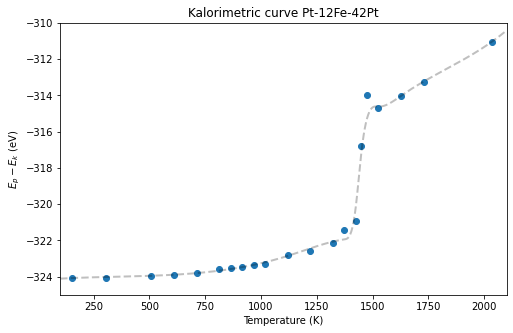

In [10]:
plt.figure(figsize=(8,5))
plt.plot(dat[0],dat[1]-dat[2],'o')
x=(dat[0])[np.arange(dat.shape[1])!=16]; 
y=(dat[1]-dat[2])[np.arange(dat.shape[1])!=16]
s=inter.UnivariateSpline(x, y, s=1.3)
xx=np.arange(100,2100,5)
plt.plot(xx,s(xx),'k--',lw=2,alpha=0.25);
plt.xlabel('Temperature (K)'); plt.ylabel('$E_p - E_k$ (eV)');
plt.title('Kalorimetric curve Pt-12Fe-42Pt')
plt.xlim(100,2100); plt.ylim(-325,-310); 